In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
def apply_features(df):
    # 1. Stationary Price Features
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # 2. EMA Gap (Trend)
    df['EMA_20'] = ta.ema(df['Close'], length=20)
    df['EMA_Gap'] = (df['Close'] - df['EMA_20']) / df['EMA_20']

    # 3. MACD (Momentum) - SAFE SEARCH
    macd = df.ta.macd(fast=12, slow=26, signal=9, append=True)
    if macd is not None:
        macdh_cols = [c for c in df.columns if 'MACDH' in c]
        df['MACD_Hist'] = df[macdh_cols[0]] if macdh_cols else 0
    else:
        df['MACD_Hist'] = 0

    # 4. ATR (Volatility) - SAFE SEARCH
    atr = df.ta.atr(length=14, append=True)
    if atr is not None:
        atr_cols = [c for c in df.columns if 'ATR' in c]
        df['ATR_Pct'] = (df[atr_cols[0]] / df['Close']) if atr_cols else 0
    else:
        df['ATR_Pct'] = 0

    # 5. MFI (Money Flow) - SAFE SEARCH
    mfi = df.ta.mfi(length=14, append=True)
    if mfi is not None:
        mfi_cols = [c for c in df.columns if 'MFI' in c]
        df['MFI'] = (df[mfi_cols[0]] / 100) if mfi_cols else 0.5
    else:
        df['MFI'] = 0.5

    # Target Logic (0.2% conviction threshold)
    df['Target'] = (df['Close'].shift(-1) > df['Close'] * 1.002).astype(int)

    # Scaling returns by 10-day volatility
    df['Vol_Scaled_Ret'] = df['Returns'] / df['Returns'].rolling(window=10).std()

    # Keep only the cleaned feature set
    cols_to_keep = ['Returns', 'MACD_Hist', 'ATR_Pct', 'MFI', "Vol_Scaled_Ret", 'EMA_Gap', 'Target']
    return df[cols_to_keep].dropna()

tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS", "ICICIBANK.NS"]
data_frames = {}

for ticker in tickers:
    try:
        df = yf.download(ticker, period="5y", interval="1d", auto_adjust=True)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        if not df.empty and len(df) > 200:
            data_frames[ticker] = apply_features(df)
            print(f"✅ Successfully processed {ticker}")
        else:
            print(f"⚠️ {ticker} had insufficient data.")
    except Exception as e:
        print(f"❌ Error on {ticker}: {e}")

[*********************100%***********************]  1 of 1 completed


✅ Successfully processed RELIANCE.NS


[*********************100%***********************]  1 of 1 completed


✅ Successfully processed TCS.NS


[*********************100%***********************]  1 of 1 completed


✅ Successfully processed HDFCBANK.NS


[*********************100%***********************]  1 of 1 completed


✅ Successfully processed INFY.NS


[*********************100%***********************]  1 of 1 completed

✅ Successfully processed ICICIBANK.NS


In [ ]:
def prepare_sequences(data_dict, time_steps=60):
    X_list, y_list = [], []
    feature_cols = ['Returns', 'MACD_Hist', 'ATR_Pct', 'MFI', 'EMA_Gap']

    scaler = StandardScaler()

    for ticker, df in data_dict.items():
        scaled_features = scaler.fit_transform(df[feature_cols])
        target = df['Target'].values

        for i in range(time_steps, len(scaled_features)):
            X_list.append(scaled_features[i-time_steps:i])
            y_list.append(target[i-1]) # Target for the day after the window

    return np.array(X_list), np.array(y_list), scaler

X, y, shared_scaler = prepare_sequences(data_frames)

# Sequential Split (80% Train, 20% Test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Total Samples: {len(X)} | Train: {len(X_train)} | Test: {len(X_test)}")

Total Samples: 5790 | Train: 4632 | Test: 1158


In [ ]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(32)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Use Nadam (Adam + Nesterov momentum) for faster convergence
from tensorflow.keras.optimizers import Nadam
model.compile(optimizer=Nadam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_stock_model.h5', monitor='val_accuracy', save_best_only=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Add this to your callbacks list in model.fit
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Updated fit call
history = model.fit(
    X_train, y_train,
    epochs=50, # Increased epochs since we have LR decay
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4947 - loss: 0.8347

145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.4948 - loss: 0.8345 - val_accuracy: 0.5579 - val_loss: 0.6898 - learning_rate: 5.0000e-04
Epoch 2/50
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5334 - loss: 0.7361

145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5333 - loss: 0.7360 - val_accuracy: 0.5630 - val_loss: 0.6983 - learning_rate: 5.0000e-04
Epoch 3/50
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5406 - loss: 0.7142

145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5406 - loss: 0.7142 - val_accuracy: 0.5734 - val_loss: 0.6990 - learning_rate: 5.0000e-04
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5417 - loss: 0.7007 - val_accuracy: 0.5691 - val_loss: 0.6972 - learning_rate: 5.0000e-04
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5582 - loss: 0.6940 - val_accuracy: 0.5656 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5547 - loss: 0.6980 - val_accuracy: 0.5501 - val_loss: 0.6953 - learning_rate: 1.0000e-04
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5664 - loss: 0.6848 - val_accuracy: 0.5604 - val_loss: 0.6981 - learning_rate: 1.0000e-04
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5612 - loss: 0.6916 - val_accuracy: 0.5596 - val_loss: 0.6980 - learning_rate: 2.0000e-05
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.56

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


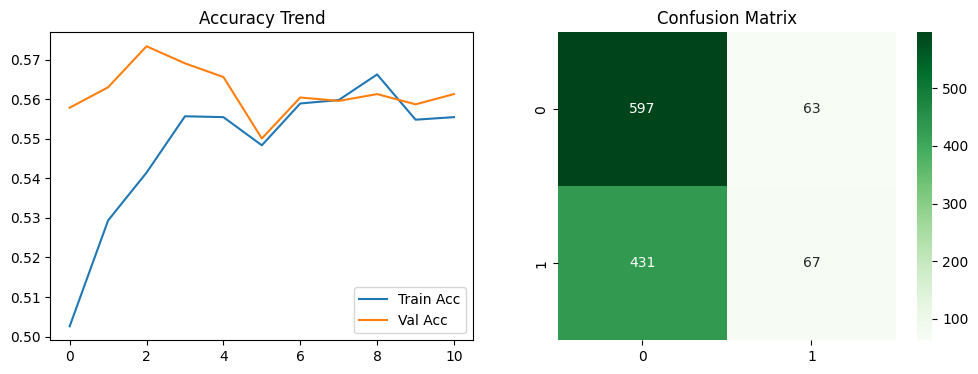

              precision    recall  f1-score   support

           0       0.58      0.90      0.71       660
           1       0.52      0.13      0.21       498

    accuracy                           0.57      1158
   macro avg       0.55      0.52      0.46      1158
weighted avg       0.55      0.57      0.49      1158



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


model = load_model('best_stock_model.h5')

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Trend')
plt.legend()

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))